## Project - Artist Recommender System

**Background**
<p>
I work at [bop.fm](https://bop.fm) where we aggregate several different music streaming providers into one service.  We provide song recommendations, via a third party service, but we dont provide artist recommendations.  I'm hoping to provide artist recommendations in the form of similar artist for a given song's artist by utilizing data from our user's listening behavior and a recommender system.
</p>

Get the data. Beware! this is around 200Mb...

In [ ]:
! curl -L -O https://www.dropbox.com/s/9la1ysbuznbjinp/listens_filtered.tar.gz\?dl\=0

In [ ]:
!pip install python-slugify

In [96]:
#the necessary imports....
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from recsys.evaluation.decision import PrecisionRecallF1
import recsys.algorithm
recsys.algorithm.VERBOSE = True
from recsys.algorithm.factorize import SVD

import json
import urllib2
import urllib
from slugify import slugify

%matplotlib inline

In [97]:
#load the dataset retrieved from server...
listens_raw_df = pd.read_csv("listens_filtered.tar.gz", compression='gzip',  header=None)

In [98]:
#set the column names
listens_raw_df.columns = ["type","song_url","artist_id", "song_id", "user_id"]
#this just a weird thing that happens on import
listens_raw_df.ix[0,0] = "song"
#look at a sample
print len(listens_raw_df)
listens_raw_df.head()

20746234


,type,song_url,artist_id,song_id,user_id
0,song,john-legend/my-shoes,john-legend,my-shoes,51c29b65a726250bef000079
1,song,john-legend/all-of-me,john-legend,all-of-me,51dc7bdc368cb5ff33000001
2,song,jazmine-sullivan/in-love-with-another-man,jazmine-sullivan,in-love-with-another-man,51dc7bdc368cb5ff33000001
3,song,justin-timberlake/mirrors,justin-timberlake,mirrors,51dc7bdc368cb5ff33000001
4,song,beyonce/pretty-hurts,beyonce,pretty-hurts,51dc7bdc368cb5ff33000001


**Data Description**
<p>The listen data represents a row each time a system user listens to a given song.  For the purposes of this exercise a listen is defined as when a user listens to at least 4 seconds of a song.</p>

**Data Dictionary** for *listens* data:
* *type* - will always be 'song'.
* *song_url* - an identifier for a given song.
* *created_at* - time stamp of when the listen. 
* *artist_id* - an identifier for the attributed artist for the given song.
* *song_id* - a secondary identifier for the song.
* *user_id* - a unique identifier for a system user.

In [99]:
#group and aggregate the data so that we can get a listen count by artist/user combination.
#this is the format needed by the recommender system library we're using.
#Since I dont have a formal "rating" a listen count is the metric used in it's place.
aggregated_df = pd.DataFrame({'count' : listens_raw_df.groupby(['user_id', 'artist_id']).size()}).reset_index()
aggregated_df.head()

,user_id,artist_id,count
0,0000039a-0330-4bbf-81c6-889e5d68ba8a,vic-mensa,1
1,00000793-66ae-4892-b602-182bf93d5ae9,drake,1
2,000007d4-e70e-4780-b989-2f41169306c2,zayn-malik,1
3,00000bb9-b326-44fa-8b3d-f5e741f86826,august-alsina,2
4,00000bb9-b326-44fa-8b3d-f5e741f86826,jhene-aiko,44


In [49]:
#bin the raw listen counts to ratings...
def get_rating_from_count(count):
    if count <= 2:
        return 1
    elif 3 <= count <= 5:
        return 2
    elif 6 <= count <= 10:
        return 3
    elif 11 <= count <= 15:
        return 4
    else:
        return 5

In [54]:
# df['newcolumn'] = df.apply(lambda x: fxy(x['A'], x['B']), axis=1)
aggregated_df["rating"] = aggregated_df.apply(lambda x: get_rating_from_count(x["count"]), axis=1)
aggregated_df.head()

,user_id,artist_id,count,rating
0,0000039a-0330-4bbf-81c6-889e5d68ba8a,vic-mensa,1,1
1,00000793-66ae-4892-b602-182bf93d5ae9,drake,1,1
2,000007d4-e70e-4780-b989-2f41169306c2,zayn-malik,1,1
3,00000bb9-b326-44fa-8b3d-f5e741f86826,august-alsina,2,1
4,00000bb9-b326-44fa-8b3d-f5e741f86826,jhene-aiko,44,5


In [34]:
#LabelEncode the artist-id and user-id and turn them into integers so the recommender system can use them.
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_artist = preprocessing.LabelEncoder()
aggregated_df["artist_enc_id"] = le_artist.fit_transform(aggregated_df.artist_id)
aggregated_df["user_enc_id"] = le_user.fit_transform(aggregated_df.user_id)

In [100]:
#show the counts for the top artists...
artist_grouped = pd.DataFrame({'count' : aggregated_df.groupby(['artist_id']).size()}).reset_index()
artist_grouped.head()

,artist_id,count
0,$amael,1
1,$ean-$homojo,9
2,$erious-klein,2
3,$g.money,1
4,$gt,1


In [141]:
#get the percentage of listens to artists to show in presentation...
print 13000.0/len(artist_grouped)
# artist_grouped.sort("count",ascending=False)["count"].sum()/20746234.0
artist_grouped.sort("count",ascending=False)["count"].head(13000).sum()/10481672.0 

0.0441732133634


0.90200151273575435

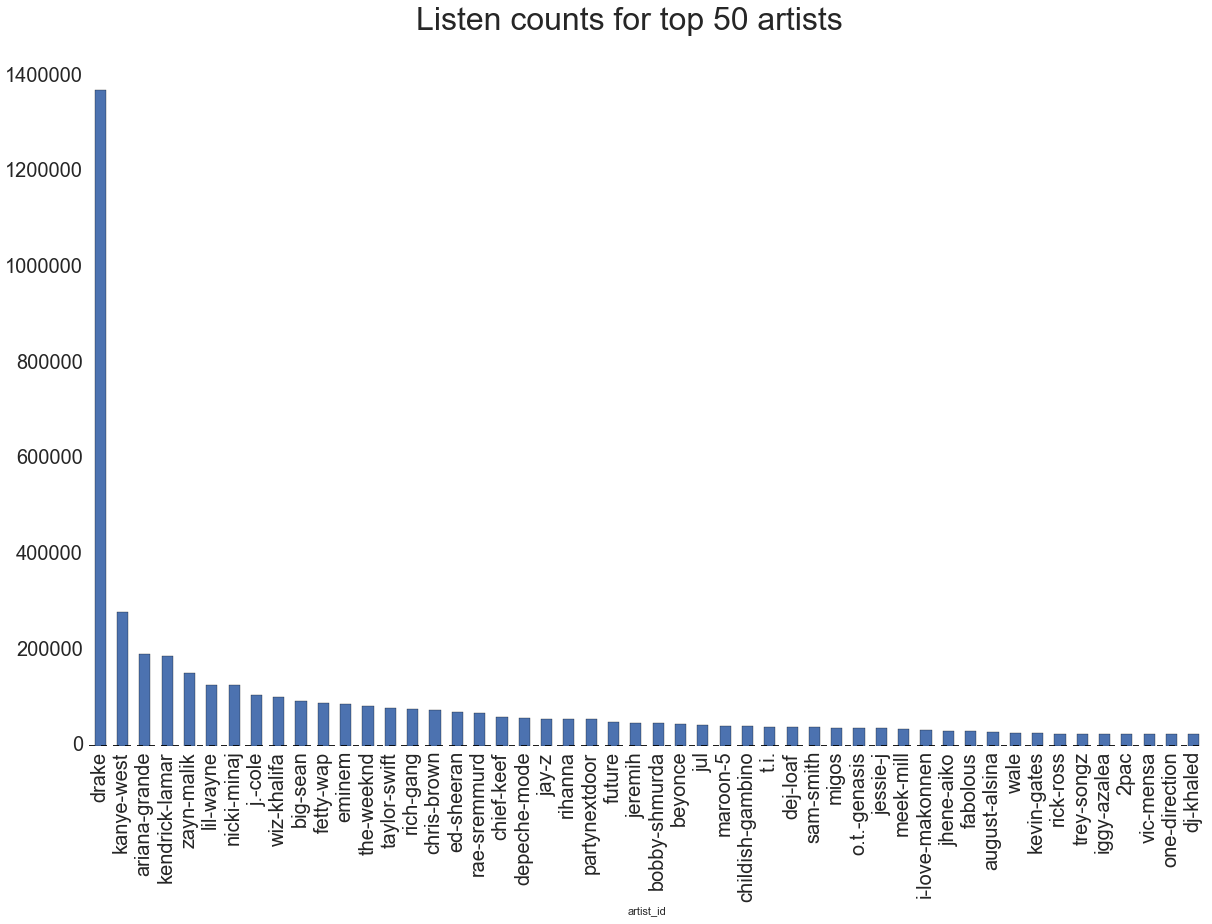

In [17]:
#the plot shows that there are a few artists at the top with the most listens and it drops off considerably after that.
#this is presents a problem when creating a recommender system becuase there isn't enough listening data 
#for those artists at the far end of the tail.
plot_set.sort(columns=["count"], ascending=False).head()
fig = plt.figure(figsize=(20,12))
fig.suptitle('Listen counts for top 50 artists', size=32)
pl = plot_set.sort(columns=["count"], ascending=False).head(50).plot(kind='bar', x="artist_id",y="count")
pl.tick_params(axis='both', which='major', labelsize=20)

In [64]:
#write to a csv so the python-recsys utility can read it.
# aggregated_df.to_csv("artist_ratings.dat", header=False, index=False, columns=["user_enc_id","artist_enc_id","count"])
aggregated_df.to_csv("artist_ratings_2.dat", header=False, index=False, columns=["user_enc_id","artist_enc_id","rating"])
# aggregated_df.head()

In [16]:
#load the recsys libraries
import recsys.algorithm
recsys.algorithm.VERBOSE = True
from recsys.algorithm.factorize import SVD
svd = SVD()

In [ ]:
#NOTE::You dont have to run this.  The matrix is saved to a file.
#load the data and create the matrix..this takes awhile.
# svd.load_data(filename='artist_ratings_3.dat', sep=',', format={'col':0, 'row':1, 'value':2, 'ids': int})
# k = 100
# svd.compute(k=k, min_values=500, pre_normalize=None, mean_center=True, post_normalize=True, savefile='artist_matrix_500')

Loading artist_ratings.dat
..........|..........|..........|..........|..........|..........|...

In [35]:
#function to get similarities...
def get_similar_artists(artist_name):
    try:
        artist_url = slugify(artist_name)
        artist_ = np.where(artist_labels == artist_url)
        answer = svd.similar(artist_[0][0])
        answers = []
        for a in answer[1::]:
            answers.append(artist_labels[a[0]])
        return answers
    except Exception as inst:
        return []


In [156]:
#test on some similar artists...
print "similar artists to lil wayne:\n" + '\n'.join(get_similar_artists('drake'))
print ""
print "similar artists to classixx:\n" + '\n'.join(get_similar_artists('classixx'))
print ""
print "similar artists to michael-jackson:\n" + '\n'.join(get_similar_artists('michael jackson'))
print ""
print "similar artists to drake:\n" + '\n'.join(get_similar_artists('drake'))
print ""
print "similar artists to bonobo:\n" + '\n'.join(get_similar_artists('bonobo'))
print ""
print "similar artists to sturgill simpson:\n" + '\n'.join(get_similar_artists('sturgill simpson'))

similar artists to lil wayne:
2-chainz
meek-mill
rick-ross
rich-gang
big-sean
drake
young-money
micachu
the-hard-lessons

similar artists to classixx:
toro-y-moi
the-alchemist
the-bots
nile-rodgers
raines
the-beloved
thom-shepherd
weebl
american-girl

similar artists to bonobo:
cliff-nobles
danger-doom
spoon
a-place-to-bury-strangers
toro-y-moi
tim-armstrong
jones
brandi-carlile
haim

similar artists to sturgill simpson:
grizfolk
bad-suns
parov-stelar
moderat
nicki-minaj-ft.-drake-lil-wayne-and-trey-dryer-remix
black-rebel-motorcycle-club
sugar
athlete
next


In [103]:
#get some recommendations from lastfm to verify
artist_memo={}
def get_last_fm_recommendations(artist_name): 
    if not artist_name in artist_memo:
        try:
            my_api_key = "93d0db9e1aa8bae64f719b923f8c9231 "
            api_url ="http://ws.audioscrobbler.com/2.0/?method=artist.getsimilar&format=json&artist=" + urllib.quote_plus(artist_name) + "&api_key=" + my_api_key    
            response = urllib2.urlopen(api_url).read()
            data = json.loads(response)    
            artists=[]
            for artist in data['similarartists']['artist'][0:9]:
                artists.append(slugify(artist['name']))
            artist_memo[artist_name] = artists
        except:
            artist_memo[artist_name] = []        
    return artist_memo[artist_name]

In [68]:
#use the bop api to get the name from the url...
def get_artist_name_from_url(artist_url):
    api_url = "https://bop.fm/a/" + artist_url + "?json=1&type=simple"
    request = urllib2.Request(api_url, headers={"BOPFM-AUTH-TOKEN" : "3980394809432743912930"})
    response = urllib2.urlopen(request).read()
    data = json.loads(response)
    return data["name"]
    
get_artist_name_from_url("drake")

u'Drake'

In [250]:
#use the bop api to get the genre from the url
def get_artist_genre_from_url(artist_url):
    try:
        api_url = "https://bop.fm/a/" + artist_url + "?json=1&type=simple"
        request = urllib2.Request(api_url, headers={"BOPFM-AUTH-TOKEN" : "3980394809432743912930"})
        response = urllib2.urlopen(request).read()
        data = json.loads(response)
        print artist_url + " - " + data["itunes_genre"]
        return data["itunes_genre"]
    except Exception as inst:
        print "Unexpected error:", inst
        return None

In [252]:
get_artist_genre_from_url("drake")

drake - Hip Hop/Rap


u'Hip Hop/Rap'

In [83]:
#get the top 200 artists to verify against.
artist_top = artist_aggregated.head(200)

In [100]:
#apply the different facets..
artist_top["artist_name"] = artist_top.apply(lambda x: get_artist_name_from_url(x["artist_id"]), axis=1)
artist_top["last_fm_recs"] = artist_top.apply(lambda x: get_last_fm_recommendations(x["artist_name"]), axis=1)
artist_grouped["genre"] = artist_grouped.apply(lambda x: get_artist_genre_from_url(x["artist_id"]), axis=1)

In [214]:
#get the metrics score per artist...
from recsys.evaluation.decision import PrecisionRecallF1
def get_eval_metrics_for_artist(artist_name):    
    gt = get_last_fm_recommendations(artist_name)
    test = get_similar_artists(artist_name)
    decision = PrecisionRecallF1()
    decision.load(gt, test)
    return decision.compute()

In [1]:
def print_precision_recall(artist_name):
    print artist_name + str(get_eval_metrics_for_artist(artist_name))

def get_precision_recall(artist_name): 
    tpl =  get_eval_metrics_for_artist(artist_name)
    return [tpl[0], tpl[1]]




-------------------------------------------------------------------------------------

###Running the algorithm for different datasets.
##Note: a lot of the compiling of the matricies was done on an ec2 instance.

In [2]:
#load the top artists..
artist_top_df = pd.read_json("artist_top.json")
artist_top_df = artist_top_df.drop("last_fm_recs_list",1)
artist_top_df.head()

,artist_id,artist_name,count,last_fm_recs
103695,gs9,GS9,5531,"[lil-bibby, bobby-shmurda, og-maco, rowdy-rebe..."
103829,gucci-mane,Gucci Mane,21498,"[chief-keef, migos, waka-flocka-flame, young-s..."
111679,hopsin,Hopsin,6509,"[hopsin-swizzz, swizzz, jarren-benton, tech-n9..."
112418,hozier,Hozier,22390,"[james-bay, george-ezra, vance-joy, sam-smith,..."
113583,i-love-makonnen,ILoveMakonnen,31741,"[father, young-thug, i-love-makonnen, rich-gan..."


In [9]:
from recsys.evaluation.decision import PrecisionRecallF1
def get_eval_metrics_for_artist2(my_recs, last_fm_recs):    
    try:
        gt = last_fm_recs
        test = my_recs
        decision = PrecisionRecallF1()
        decision.load(gt, test)
        pre,recall,f1 = decision.compute()
        return f1
    except:
        return None

In [142]:
matrix_map = {"artist_matrix_100":"100",
              "artist_matrix_500":"500",
              "artist_matrix_800":"800",
              "artist_matrix_1000":"1000",
              "artist_matrix_2_100":"bin_100",
              "artist_matrix_2_500":"bin_500",
              "artist_matrix_2_800":"bin_800",
              "artist_matrix_2_1000":"bin_1000",
              "artist_matrix_3_100" : "genre_100",
              "artist_matrix_3_500" : "genre_500",
              "artist_matrix_3_800" : "genre_800",
              "artist_matrix_3_1000" : "genre_1000"
             }

In [148]:
#create my columns and f1 values...
for key, value in matrix_map.iteritems():    
    svd = SVD(filename=key)
    artist_top_df["my_recs_" + value] = artist_top_df.apply(lambda x: get_similar_artists(x["artist_id"]), axis=1)
    artist_top_df["f1_" + value] = artist_top_df.apply(lambda x: get_eval_metrics_for_artist2(x["my_recs_" + value], x["last_fm_recs"]), axis=1)


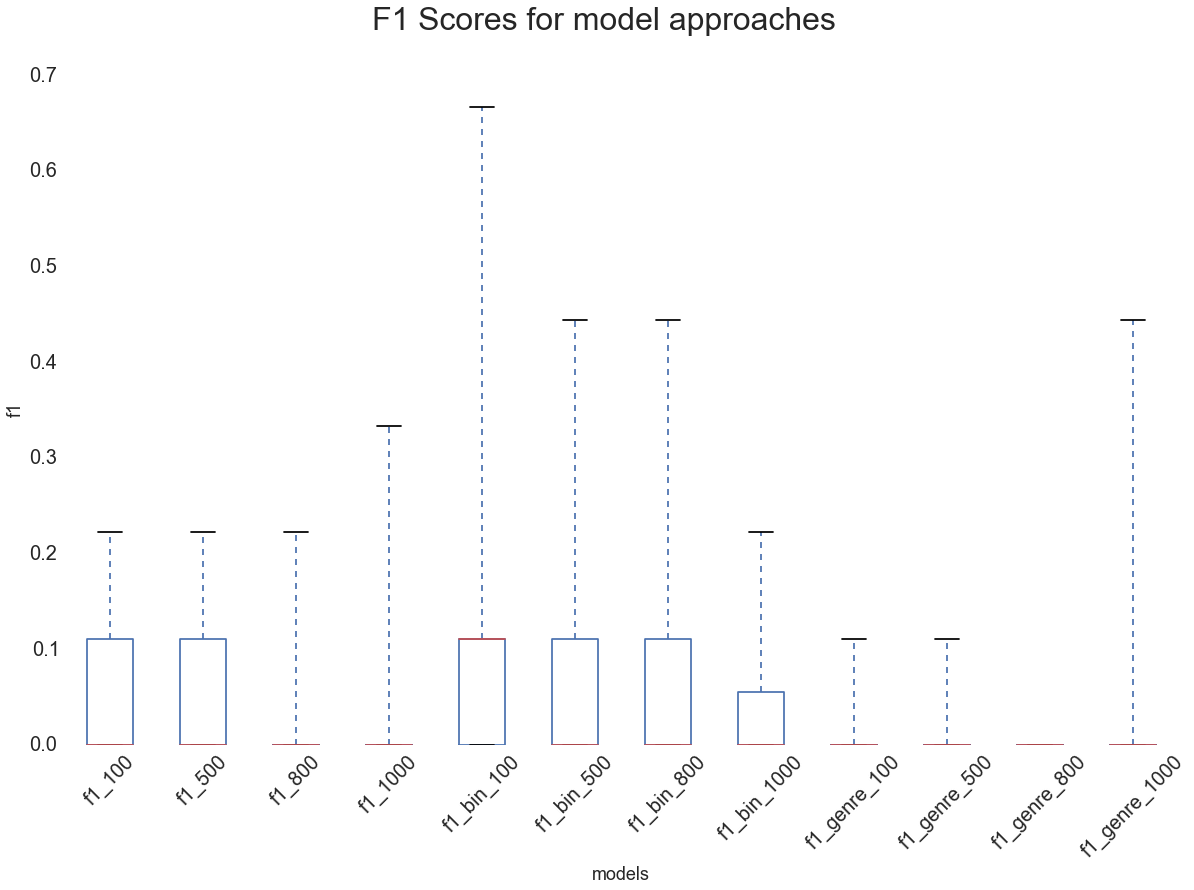

In [149]:
fig = plt.figure(figsize=(20,12))
fig.suptitle('F1 Scores for model approaches', size=32)
plt.xlabel('models', fontsize=18)
plt.ylabel('f1', fontsize=18)
p = artist_top_df.boxplot(return_type='axes', column=["f1_100", "f1_500", "f1_800", "f1_1000","f1_bin_100", "f1_bin_500", "f1_bin_800", "f1_bin_1000","f1_genre_100", "f1_genre_500","f1_genre_800","f1_genre_1000"],rot="45")
p.tick_params(axis='both', which='major', labelsize=20)